In [1]:
trial_number_ml = "001"
random_state_init = 42

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model1_rna_b_rna_n
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model1_rna_b_rna_n


In [4]:
def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model1_files = ['../../data_for_ml/ml_datasets_set2/model1_rna_bin_non_rna_bin/data.pkl']

# Load datasets
model1_df = load_and_concatenate_datasets(model1_files)

# Preprocess datasets
X1, y1 = preprocess_data(model1_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X1, y1)

# Output shapes
print(f"Model 1 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 1 - Training set size: 3137, Test set size: 785


In [5]:
X_train[0]

array([0, 0, 0, ..., 0, 0, 0])

In [6]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=-1)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=-1)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=-1) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 14:30:36,273] A new study created in memory with name: no-name-d3fe1f50-d01f-40d6-b1ff-c5b52e701d97


[I 2024-05-01 14:32:07,110] Trial 0 finished with value: 0.6324586799947175 and parameters: {'n_estimators': 108, 'max_depth': 87, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6324586799947175.


[I 2024-05-01 14:32:21,530] Trial 6 finished with value: 0.6069535448348724 and parameters: {'n_estimators': 150, 'max_depth': 50, 'min_samples_split': 18, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: 0.6324586799947175.


[I 2024-05-01 14:32:27,688] Trial 3 finished with value: 0.6075894716524954 and parameters: {'n_estimators': 172, 'max_depth': 32, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 0.6324586799947175.


[I 2024-05-01 14:32:54,777] Trial 15 finished with value: 0.6228964130070399 and parameters: {'n_estimators': 194, 'max_depth': 27, 'min_samples_split': 19, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6324586799947175.


[I 2024-05-01 14:33:43,992] Trial 7 finished with value: 0.6130090716077977 and parameters: {'n_estimators': 313, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.6324586799947175.


[I 2024-05-01 14:33:46,296] Trial 5 finished with value: 0.6200205203222301 and parameters: {'n_estimators': 292, 'max_depth': 74, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.6324586799947175.


[I 2024-05-01 14:33:54,297] Trial 21 pruned. 


[I 2024-05-01 14:34:03,791] Trial 19 pruned. 


[I 2024-05-01 14:34:21,703] Trial 8 finished with value: 0.6168342831601297 and parameters: {'n_estimators': 359, 'max_depth': 78, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.6324586799947175.


[I 2024-05-01 14:34:23,906] Trial 14 finished with value: 0.6228948892207357 and parameters: {'n_estimators': 350, 'max_depth': 59, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6324586799947175.


[I 2024-05-01 14:34:44,880] Trial 1 finished with value: 0.6171532624264773 and parameters: {'n_estimators': 421, 'max_depth': 35, 'min_samples_split': 17, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: 0.6324586799947175.


[I 2024-05-01 14:35:06,795] Trial 18 finished with value: 0.627036540395575 and parameters: {'n_estimators': 270, 'max_depth': 73, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.6324586799947175.


[I 2024-05-01 14:35:20,357] Trial 9 finished with value: 0.6257555440425036 and parameters: {'n_estimators': 447, 'max_depth': 31, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6324586799947175.


[I 2024-05-01 14:35:23,817] Trial 12 pruned. 


[I 2024-05-01 14:35:41,612] Trial 13 finished with value: 0.6254396123487642 and parameters: {'n_estimators': 469, 'max_depth': 44, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6324586799947175.


[I 2024-05-01 14:35:44,829] Trial 23 finished with value: 0.62034153130365 and parameters: {'n_estimators': 162, 'max_depth': 95, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.6324586799947175.


[I 2024-05-01 14:35:54,283] Trial 28 pruned. 


[I 2024-05-01 14:36:53,800] Trial 2 finished with value: 0.6263975660053435 and parameters: {'n_estimators': 616, 'max_depth': 64, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.6324586799947175.


[I 2024-05-01 14:36:59,922] Trial 24 finished with value: 0.6257631629740245 and parameters: {'n_estimators': 265, 'max_depth': 100, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.6324586799947175.


[I 2024-05-01 14:38:17,297] Trial 10 finished with value: 0.6327735958309206 and parameters: {'n_estimators': 724, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.6327735958309206.


[I 2024-05-01 14:38:42,687] Trial 16 finished with value: 0.6251241885837929 and parameters: {'n_estimators': 744, 'max_depth': 40, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.6327735958309206.


[I 2024-05-01 14:38:47,385] Trial 26 finished with value: 0.6263960422190392 and parameters: {'n_estimators': 405, 'max_depth': 44, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.6327735958309206.


[I 2024-05-01 14:38:57,873] Trial 31 pruned. 


[I 2024-05-01 14:38:57,959] Trial 11 finished with value: 0.6283119495321976 and parameters: {'n_estimators': 766, 'max_depth': 96, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.6327735958309206.


[I 2024-05-01 14:39:42,510] Trial 22 pruned. 


[I 2024-05-01 14:40:10,428] Trial 4 finished with value: 0.6273529800180823 and parameters: {'n_estimators': 920, 'max_depth': 71, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.6327735958309206.


[I 2024-05-01 14:40:29,046] Trial 17 pruned. 


[I 2024-05-01 14:40:29,903] Trial 25 finished with value: 0.6248072410325175 and parameters: {'n_estimators': 617, 'max_depth': 79, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 10 with value: 0.6327735958309206.


[I 2024-05-01 14:40:39,262] Trial 27 pruned. 


[I 2024-05-01 14:42:07,020] Trial 38 pruned. 


[I 2024-05-01 14:42:10,496] Trial 29 finished with value: 0.6289499080648929 and parameters: {'n_estimators': 602, 'max_depth': 98, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.6327735958309206.


[I 2024-05-01 14:42:23,783] Trial 39 pruned. 


[I 2024-05-01 14:42:24,711] Trial 45 pruned. 


[I 2024-05-01 14:42:30,349] Trial 46 pruned. 


[I 2024-05-01 14:42:34,467] Trial 30 finished with value: 0.6321346214406891 and parameters: {'n_estimators': 609, 'max_depth': 97, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.6327735958309206.


[I 2024-05-01 14:42:47,278] Trial 32 pruned. 


[I 2024-05-01 14:42:48,344] Trial 20 finished with value: 0.6321346214406892 and parameters: {'n_estimators': 990, 'max_depth': 40, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 10 with value: 0.6327735958309206.


[I 2024-05-01 14:42:57,822] Trial 33 finished with value: 0.6273534879468503 and parameters: {'n_estimators': 663, 'max_depth': 100, 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.6327735958309206.


[I 2024-05-01 14:43:20,442] Trial 42 pruned. 


[I 2024-05-01 14:43:25,179] Trial 34 finished with value: 0.6241621714970692 and parameters: {'n_estimators': 712, 'max_depth': 80, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.6327735958309206.


[I 2024-05-01 14:43:25,325] Trial 43 pruned. 


[I 2024-05-01 14:43:34,835] Trial 44 pruned. 


[I 2024-05-01 14:44:19,301] Trial 36 finished with value: 0.6273519641605461 and parameters: {'n_estimators': 792, 'max_depth': 85, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.6327735958309206.


[I 2024-05-01 14:44:21,098] Trial 35 finished with value: 0.6283089019595891 and parameters: {'n_estimators': 818, 'max_depth': 87, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.6327735958309206.


[I 2024-05-01 14:44:21,528] Trial 47 pruned. 


[I 2024-05-01 14:44:22,455] Trial 48 pruned. 


[I 2024-05-01 14:44:22,805] Trial 37 finished with value: 0.631177175712878 and parameters: {'n_estimators': 727, 'max_depth': 84, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.6327735958309206.


[I 2024-05-01 14:44:22,843] Trial 49 pruned. 


[I 2024-05-01 14:44:38,475] Trial 40 finished with value: 0.62767195928443 and parameters: {'n_estimators': 865, 'max_depth': 87, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.6327735958309206.


[I 2024-05-01 14:44:38,607] Trial 41 finished with value: 0.6276704354981257 and parameters: {'n_estimators': 883, 'max_depth': 88, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.6327735958309206.


Best trial for RandomForestClassifier:
  Value: 0.6327735958309206
  Params: 
    n_estimators: 724
    max_depth: 22
    min_samples_split: 10
    min_samples_leaf: 1
    max_features: sqrt

Best hyperparameters for RandomForestClassifier: {'n_estimators': 724, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


[I 2024-05-01 14:44:56,513] A new study created in memory with name: no-name-7f214556-b75a-462b-b415-b58c762d3f00


RandomForestClassifier accuracy: 0.6268



[I 2024-05-01 14:45:11,645] Trial 6 finished with value: 0.6008934467030344 and parameters: {'n_estimators': 125, 'max_depth': 4, 'learning_rate': 0.23077579304261947, 'min_child_weight': 2, 'subsample': 0.9315559028185263, 'colsample_bytree': 0.5804668763029102, 'gamma': 1.8314833826425725, 'reg_lambda': 0.05746413626573709, 'reg_alpha': 3.1362814805511356}. Best is trial 6 with value: 0.6008934467030344.


[I 2024-05-01 14:45:17,655] Trial 5 finished with value: 0.6079099747051474 and parameters: {'n_estimators': 196, 'max_depth': 5, 'learning_rate': 0.2496553917942383, 'min_child_weight': 6, 'subsample': 0.8126185921208756, 'colsample_bytree': 0.6760956559059006, 'gamma': 4.521902762106195, 'reg_lambda': 0.16989359200836412, 'reg_alpha': 0.15324282600761527}. Best is trial 5 with value: 0.6079099747051474.


[I 2024-05-01 14:45:18,920] Trial 8 finished with value: 0.5977127967573826 and parameters: {'n_estimators': 111, 'max_depth': 7, 'learning_rate': 0.15123841069109598, 'min_child_weight': 7, 'subsample': 0.7221118961856944, 'colsample_bytree': 0.5433607771106838, 'gamma': 1.6022428333135819, 'reg_lambda': 0.015296926665697114, 'reg_alpha': 0.3149862065022607}. Best is trial 5 with value: 0.6079099747051474.


[I 2024-05-01 14:45:19,461] Trial 1 finished with value: 0.6079059112750028 and parameters: {'n_estimators': 160, 'max_depth': 6, 'learning_rate': 0.1948479302501341, 'min_child_weight': 8, 'subsample': 0.6231384492506009, 'colsample_bytree': 0.9849930280417292, 'gamma': 3.5931913498421935, 'reg_lambda': 0.9382538520166134, 'reg_alpha': 0.24636476046009223}. Best is trial 5 with value: 0.6079099747051474.


[I 2024-05-01 14:45:19,940] Trial 10 finished with value: 0.6063150783734089 and parameters: {'n_estimators': 147, 'max_depth': 9, 'learning_rate': 0.1364485099109473, 'min_child_weight': 3, 'subsample': 0.7663961477601415, 'colsample_bytree': 0.7765608475513899, 'gamma': 3.8768542406094615, 'reg_lambda': 0.40813449432252247, 'reg_alpha': 0.02172951410438152}. Best is trial 5 with value: 0.6079099747051474.


[I 2024-05-01 14:45:22,104] Trial 13 pruned. 


[I 2024-05-01 14:45:22,270] Trial 21 pruned. 


[I 2024-05-01 14:45:23,392] Trial 19 pruned. 


[I 2024-05-01 14:45:24,197] Trial 12 pruned. 


[I 2024-05-01 14:45:25,557] Trial 23 pruned. 


[I 2024-05-01 14:45:27,184] Trial 15 pruned. 


[I 2024-05-01 14:45:27,606] Trial 22 pruned. 


[I 2024-05-01 14:45:28,142] Trial 16 finished with value: 0.6075869320086551 and parameters: {'n_estimators': 169, 'max_depth': 6, 'learning_rate': 0.09721644409368849, 'min_child_weight': 10, 'subsample': 0.6882487228721543, 'colsample_bytree': 0.5391883493678667, 'gamma': 1.5263729957742544, 'reg_lambda': 0.01901443646000777, 'reg_alpha': 0.034131717469974086}. Best is trial 5 with value: 0.6079099747051474.


[I 2024-05-01 14:45:30,536] Trial 25 pruned. 


[I 2024-05-01 14:45:31,331] Trial 3 pruned. 


[I 2024-05-01 14:45:32,464] Trial 18 finished with value: 0.6040771442212944 and parameters: {'n_estimators': 123, 'max_depth': 7, 'learning_rate': 0.0608454877406156, 'min_child_weight': 7, 'subsample': 0.5717206645718841, 'colsample_bytree': 0.9602297709656495, 'gamma': 4.956124777983723, 'reg_lambda': 1.5238112645431727, 'reg_alpha': 0.021034524777880308}. Best is trial 5 with value: 0.6079099747051474.


[I 2024-05-01 14:45:32,524] Trial 7 pruned. 


[I 2024-05-01 14:45:34,184] Trial 14 pruned. 


[I 2024-05-01 14:45:34,712] Trial 29 pruned. 


[I 2024-05-01 14:45:34,943] Trial 28 pruned. 


[I 2024-05-01 14:45:35,446] Trial 20 pruned. 


[I 2024-05-01 14:45:36,249] Trial 4 pruned. 


[I 2024-05-01 14:45:37,879] Trial 26 pruned. 


[I 2024-05-01 14:45:39,208] Trial 32 pruned. 


[I 2024-05-01 14:45:39,256] Trial 11 finished with value: 0.6069489734759598 and parameters: {'n_estimators': 538, 'max_depth': 4, 'learning_rate': 0.2915700195165637, 'min_child_weight': 6, 'subsample': 0.6765860550653001, 'colsample_bytree': 0.7225101952451285, 'gamma': 2.125567202043599, 'reg_lambda': 0.6277540452590596, 'reg_alpha': 6.402764531862521}. Best is trial 5 with value: 0.6079099747051474.


[I 2024-05-01 14:45:39,935] Trial 34 pruned. 


[I 2024-05-01 14:45:41,543] Trial 39 pruned. 


[I 2024-05-01 14:45:41,810] Trial 27 pruned. 


[I 2024-05-01 14:45:41,903] Trial 2 finished with value: 0.6114096039171467 and parameters: {'n_estimators': 270, 'max_depth': 9, 'learning_rate': 0.1659390478308453, 'min_child_weight': 9, 'subsample': 0.7509445754998807, 'colsample_bytree': 0.6912002608484331, 'gamma': 1.8130290030890106, 'reg_lambda': 0.018746213506939974, 'reg_alpha': 0.38459190894602446}. Best is trial 2 with value: 0.6114096039171467.


[I 2024-05-01 14:45:43,166] Trial 38 pruned. 


[I 2024-05-01 14:45:43,459] Trial 30 pruned. 


[I 2024-05-01 14:45:43,944] Trial 35 pruned. 


[I 2024-05-01 14:45:44,978] Trial 36 pruned. 


[I 2024-05-01 14:45:45,477] Trial 40 pruned. 


[I 2024-05-01 14:45:46,970] Trial 9 pruned. 


[I 2024-05-01 14:45:47,009] Trial 31 pruned. 


[I 2024-05-01 14:45:47,013] Trial 46 pruned. 


[I 2024-05-01 14:45:47,908] Trial 45 pruned. 


[I 2024-05-01 14:45:47,979] Trial 44 pruned. 


[I 2024-05-01 14:45:48,734] Trial 47 pruned. 


[I 2024-05-01 14:45:50,864] Trial 49 pruned. 


[I 2024-05-01 14:45:50,892] Trial 33 pruned. 


[I 2024-05-01 14:45:50,985] Trial 43 pruned. 


[I 2024-05-01 14:45:51,962] Trial 17 pruned. 


[I 2024-05-01 14:45:54,332] Trial 24 finished with value: 0.6079048954174666 and parameters: {'n_estimators': 467, 'max_depth': 6, 'learning_rate': 0.08076003734523471, 'min_child_weight': 1, 'subsample': 0.7009816683271324, 'colsample_bytree': 0.593364017465648, 'gamma': 4.384641959068663, 'reg_lambda': 0.25699963816854016, 'reg_alpha': 4.476549441584309}. Best is trial 2 with value: 0.6114096039171467.


[I 2024-05-01 14:45:56,251] Trial 0 finished with value: 0.6075833765072786 and parameters: {'n_estimators': 756, 'max_depth': 3, 'learning_rate': 0.19473443904678725, 'min_child_weight': 1, 'subsample': 0.8439661390241462, 'colsample_bytree': 0.5513384939721726, 'gamma': 2.236942087660368, 'reg_lambda': 0.020751164371640304, 'reg_alpha': 0.4462372086792547}. Best is trial 2 with value: 0.6114096039171467.


[I 2024-05-01 14:45:57,230] Trial 37 finished with value: 0.613324495372769 and parameters: {'n_estimators': 226, 'max_depth': 8, 'learning_rate': 0.13470618568464995, 'min_child_weight': 6, 'subsample': 0.7995046659482125, 'colsample_bytree': 0.7070250833551986, 'gamma': 3.058769756211789, 'reg_lambda': 2.143538894750219, 'reg_alpha': 0.0106775032295119}. Best is trial 37 with value: 0.613324495372769.


[I 2024-05-01 14:46:01,761] Trial 42 finished with value: 0.6088603094302055 and parameters: {'n_estimators': 207, 'max_depth': 6, 'learning_rate': 0.11616425325183705, 'min_child_weight': 7, 'subsample': 0.6325745717332713, 'colsample_bytree': 0.6941027672619665, 'gamma': 0.22441554009110254, 'reg_lambda': 0.26803511209674513, 'reg_alpha': 0.12004342694256388}. Best is trial 37 with value: 0.613324495372769.


[I 2024-05-01 14:46:02,125] Trial 48 finished with value: 0.6069454179745832 and parameters: {'n_estimators': 253, 'max_depth': 5, 'learning_rate': 0.17551515368599777, 'min_child_weight': 9, 'subsample': 0.6979644340688225, 'colsample_bytree': 0.6818603902523039, 'gamma': 2.6199644412313345, 'reg_lambda': 0.031643723237842036, 'reg_alpha': 0.13039628007759763}. Best is trial 37 with value: 0.613324495372769.


[I 2024-05-01 14:46:08,308] Trial 41 finished with value: 0.604396123487642 and parameters: {'n_estimators': 219, 'max_depth': 6, 'learning_rate': 0.12356583519732611, 'min_child_weight': 7, 'subsample': 0.6144525658346328, 'colsample_bytree': 0.6924606862938687, 'gamma': 0.2125380129919443, 'reg_lambda': 0.026636453528478665, 'reg_alpha': 0.12707261218371615}. Best is trial 37 with value: 0.613324495372769.


Best trial for XGBClassifier:
  Value: 0.613324495372769
  Params: 
    n_estimators: 226
    max_depth: 8
    learning_rate: 0.13470618568464995
    min_child_weight: 6
    subsample: 0.7995046659482125
    colsample_bytree: 0.7070250833551986
    gamma: 3.058769756211789
    reg_lambda: 2.143538894750219
    reg_alpha: 0.0106775032295119

Best hyperparameters for XGBClassifier: {'n_estimators': 226, 'max_depth': 8, 'learning_rate': 0.13470618568464995, 'min_child_weight': 6, 'subsample': 0.7995046659482125, 'colsample_bytree': 0.7070250833551986, 'gamma': 3.058769756211789, 'reg_lambda': 2.143538894750219, 'reg_alpha': 0.0106775032295119}


[I 2024-05-01 14:46:34,614] A new study created in memory with name: no-name-63f0d276-fd42-4e20-85a7-17a70c138ffc


XGBClassifier accuracy: 0.5898



[I 2024-05-01 14:46:38,935] Trial 14 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 98, 'max_depth': 2, 'learning_rate': 0.4330008864891684, 'n_estimators': 474, 'min_child_weight': 0.002601446898700087, 'min_child_samples': 1391, 'subsample': 0.8947687932899928, 'colsample_bytree': 0.8253761147692837, 'reg_alpha': 1.5467068376103737e-10, 'reg_lambda': 2.899731805147237e-08}. Best is trial 14 with value: 0.4995215311004785.


[I 2024-05-01 14:46:39,211] Trial 8 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 87, 'max_depth': 7, 'learning_rate': 0.21436844031512775, 'n_estimators': 626, 'min_child_weight': 0.004796445154409151, 'min_child_samples': 1940, 'subsample': 0.80128183997948, 'colsample_bytree': 0.9274644129908616, 'reg_alpha': 1.5198816333119985e-10, 'reg_lambda': 0.000184513798870725}. Best is trial 14 with value: 0.4995215311004785.


[I 2024-05-01 14:46:39,645] Trial 12 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 48, 'max_depth': 11, 'learning_rate': 0.06510040992360387, 'n_estimators': 645, 'min_child_weight': 0.0012700455984167322, 'min_child_samples': 1847, 'subsample': 0.8652139046446957, 'colsample_bytree': 0.9342061571261034, 'reg_alpha': 1.6403430885743324e-09, 'reg_lambda': 0.006072739470566369}. Best is trial 14 with value: 0.4995215311004785.


[I 2024-05-01 14:46:39,846] Trial 13 finished with value: 0.5715691951360741 and parameters: {'boosting_type': 'goss', 'num_leaves': 45, 'max_depth': -1, 'learning_rate': 0.015763464546560253, 'n_estimators': 205, 'min_child_weight': 0.009210525019224649, 'min_child_samples': 1004, 'subsample': 0.8211797509227811, 'colsample_bytree': 0.8674561696726637, 'reg_alpha': 1.7566587589172242e-05, 'reg_lambda': 3.807795208678622e-06}. Best is trial 13 with value: 0.5715691951360741.


[I 2024-05-01 14:46:39,976] Trial 6 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 84, 'max_depth': 0, 'learning_rate': 0.13951358209331674, 'n_estimators': 839, 'min_child_weight': 0.004613391369430574, 'min_child_samples': 1991, 'subsample': 0.8261250053962179, 'colsample_bytree': 0.8183906187209673, 'reg_alpha': 0.6392473897222398, 'reg_lambda': 2.429283335305724e-06}. Best is trial 13 with value: 0.5715691951360741.


[I 2024-05-01 14:46:40,018] Trial 15 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 82, 'max_depth': 12, 'learning_rate': 0.4279944512397811, 'n_estimators': 829, 'min_child_weight': 0.0825741990236663, 'min_child_samples': 1634, 'subsample': 0.9444726159940979, 'colsample_bytree': 0.9995321979929144, 'reg_alpha': 0.0001765276465476861, 'reg_lambda': 1.4810225849145001e-08}. Best is trial 13 with value: 0.5715691951360741.


[I 2024-05-01 14:46:40,426] Trial 16 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'max_depth': -1, 'learning_rate': 0.46980224245470936, 'n_estimators': 818, 'min_child_weight': 0.002009753487774558, 'min_child_samples': 1454, 'subsample': 0.8591602916314789, 'colsample_bytree': 0.8604013382763387, 'reg_alpha': 0.0024080635337842857, 'reg_lambda': 0.03210706282422545}. Best is trial 13 with value: 0.5715691951360741.


[I 2024-05-01 14:46:40,622] Trial 0 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 78, 'max_depth': 2, 'learning_rate': 0.03465577615067429, 'n_estimators': 984, 'min_child_weight': 0.0012657526086863131, 'min_child_samples': 1385, 'subsample': 0.954931919617332, 'colsample_bytree': 0.9151008561571721, 'reg_alpha': 0.8586379280426176, 'reg_lambda': 7.608090996190376e-10}. Best is trial 13 with value: 0.5715691951360741.


[I 2024-05-01 14:46:41,786] Trial 11 finished with value: 0.577942177389043 and parameters: {'boosting_type': 'dart', 'num_leaves': 69, 'max_depth': 3, 'learning_rate': 0.33750372190394207, 'n_estimators': 134, 'min_child_weight': 0.014714735728505277, 'min_child_samples': 901, 'subsample': 0.8672616968150846, 'colsample_bytree': 0.8850980810500795, 'reg_alpha': 4.971013305995294e-07, 'reg_lambda': 0.001203483715580346}. Best is trial 11 with value: 0.577942177389043.


[I 2024-05-01 14:46:42,558] Trial 24 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': 7, 'learning_rate': 0.21132473806017235, 'n_estimators': 117, 'min_child_weight': 0.00890948543123648, 'min_child_samples': 1409, 'subsample': 0.8335719137309502, 'colsample_bytree': 0.8375976379383483, 'reg_alpha': 1.4684336456600635e-05, 'reg_lambda': 0.09592230481690675}. Best is trial 11 with value: 0.577942177389043.


[I 2024-05-01 14:46:43,336] Trial 23 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 94, 'max_depth': 3, 'learning_rate': 0.46775585720673124, 'n_estimators': 410, 'min_child_weight': 0.006227703044430588, 'min_child_samples': 1611, 'subsample': 0.9435848552049813, 'colsample_bytree': 0.9050442839463706, 'reg_alpha': 1.6131945420839535e-05, 'reg_lambda': 0.13860256936491192}. Best is trial 11 with value: 0.577942177389043.


[I 2024-05-01 14:46:43,809] Trial 19 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 96, 'max_depth': 3, 'learning_rate': 0.1103587460792484, 'n_estimators': 596, 'min_child_weight': 0.006286018582033706, 'min_child_samples': 1656, 'subsample': 0.8939272117256787, 'colsample_bytree': 0.835205041287109, 'reg_alpha': 1.573371697709787e-07, 'reg_lambda': 0.00015219649926768785}. Best is trial 11 with value: 0.577942177389043.


[I 2024-05-01 14:46:44,662] Trial 20 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'max_depth': 8, 'learning_rate': 0.14430692310171273, 'n_estimators': 883, 'min_child_weight': 0.004659059576394722, 'min_child_samples': 1318, 'subsample': 0.8324635554266518, 'colsample_bytree': 0.8997699074173378, 'reg_alpha': 4.965779635868116e-05, 'reg_lambda': 2.8364811755574094e-05}. Best is trial 11 with value: 0.577942177389043.


[I 2024-05-01 14:46:45,103] Trial 26 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 94, 'max_depth': 7, 'learning_rate': 0.06154640792877295, 'n_estimators': 461, 'min_child_weight': 0.0030216148621578782, 'min_child_samples': 1484, 'subsample': 0.8087650482523225, 'colsample_bytree': 0.9309410207332687, 'reg_alpha': 3.2159429995705283e-10, 'reg_lambda': 5.502265169360346e-09}. Best is trial 11 with value: 0.577942177389043.


[I 2024-05-01 14:46:45,734] Trial 5 finished with value: 0.5760313493635654 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'max_depth': 5, 'learning_rate': 0.42907345271152764, 'n_estimators': 455, 'min_child_weight': 0.004005871933402588, 'min_child_samples': 1108, 'subsample': 0.9488173468385879, 'colsample_bytree': 0.8143744467659765, 'reg_alpha': 3.389920760307377e-07, 'reg_lambda': 8.28227411872216e-08}. Best is trial 11 with value: 0.577942177389043.


[I 2024-05-01 14:46:46,496] Trial 4 finished with value: 0.5878193602129237 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 91, 'max_depth': 14, 'learning_rate': 0.4611525873103443, 'n_estimators': 267, 'min_child_weight': 0.0022549238156887043, 'min_child_samples': 395, 'subsample': 0.8136238694319596, 'colsample_bytree': 0.9564479514505154, 'reg_alpha': 0.1919943983808919, 'reg_lambda': 1.2398773134376524e-10}. Best is trial 4 with value: 0.5878193602129237.


[I 2024-05-01 14:46:47,720] Trial 18 finished with value: 0.572524609148813 and parameters: {'boosting_type': 'goss', 'num_leaves': 82, 'max_depth': 12, 'learning_rate': 0.223430825589506, 'n_estimators': 444, 'min_child_weight': 0.029289686640129944, 'min_child_samples': 1021, 'subsample': 0.964210483602108, 'colsample_bytree': 0.966331530742841, 'reg_alpha': 0.007085991315430153, 'reg_lambda': 5.646837180512508e-07}. Best is trial 4 with value: 0.5878193602129237.


[I 2024-05-01 14:46:47,868] Trial 28 finished with value: 0.5760313493635653 and parameters: {'boosting_type': 'goss', 'num_leaves': 32, 'max_depth': 6, 'learning_rate': 0.3440999183063954, 'n_estimators': 117, 'min_child_weight': 0.027796179256758983, 'min_child_samples': 643, 'subsample': 0.8930866242619208, 'colsample_bytree': 0.8689317639194202, 'reg_alpha': 7.71336672534297e-08, 'reg_lambda': 2.0019302681006794e-05}. Best is trial 4 with value: 0.5878193602129237.


[I 2024-05-01 14:46:48,545] Trial 29 finished with value: 0.5824094109042147 and parameters: {'boosting_type': 'goss', 'num_leaves': 31, 'max_depth': 5, 'learning_rate': 0.32606289775249675, 'n_estimators': 107, 'min_child_weight': 0.02253850249958684, 'min_child_samples': 578, 'subsample': 0.8466452252187857, 'colsample_bytree': 0.8747468689345498, 'reg_alpha': 2.2641697255858452e-07, 'reg_lambda': 5.319014575774828e-06}. Best is trial 4 with value: 0.5878193602129237.


[I 2024-05-01 14:46:49,287] Trial 21 finished with value: 0.5789031786182306 and parameters: {'boosting_type': 'goss', 'num_leaves': 80, 'max_depth': 11, 'learning_rate': 0.05084951852738784, 'n_estimators': 341, 'min_child_weight': 0.00610545423321863, 'min_child_samples': 712, 'subsample': 0.9094433272650128, 'colsample_bytree': 0.9629753731074352, 'reg_alpha': 4.1128593867900024e-08, 'reg_lambda': 0.0044132987918603945}. Best is trial 4 with value: 0.5878193602129237.


[I 2024-05-01 14:46:49,311] Trial 30 finished with value: 0.569334816485336 and parameters: {'boosting_type': 'goss', 'num_leaves': 64, 'max_depth': 5, 'learning_rate': 0.3198961808469229, 'n_estimators': 140, 'min_child_weight': 0.02444294222668587, 'min_child_samples': 641, 'subsample': 0.9953033609462989, 'colsample_bytree': 0.8731204416980206, 'reg_alpha': 1.278185990915259e-07, 'reg_lambda': 1.0143185581315977e-06}. Best is trial 4 with value: 0.5878193602129237.


[I 2024-05-01 14:46:49,816] Trial 31 finished with value: 0.5820914474954033 and parameters: {'boosting_type': 'goss', 'num_leaves': 63, 'max_depth': 15, 'learning_rate': 0.3355057522325686, 'n_estimators': 104, 'min_child_weight': 0.023048990446028796, 'min_child_samples': 540, 'subsample': 0.9955713799015415, 'colsample_bytree': 0.8725744178428744, 'reg_alpha': 1.554781391516749e-07, 'reg_lambda': 1.1559451797179516e-06}. Best is trial 4 with value: 0.5878193602129237.


[I 2024-05-01 14:46:51,531] Trial 9 finished with value: 0.573481039019088 and parameters: {'boosting_type': 'goss', 'num_leaves': 66, 'max_depth': 15, 'learning_rate': 0.10468324940526892, 'n_estimators': 879, 'min_child_weight': 0.0036363190641035383, 'min_child_samples': 1128, 'subsample': 0.8338129319311937, 'colsample_bytree': 0.8775989552583289, 'reg_alpha': 2.5923311493165038e-05, 'reg_lambda': 0.00035035271493350704}. Best is trial 4 with value: 0.5878193602129237.


[I 2024-05-01 14:46:54,365] Trial 2 finished with value: 0.5852741291561271 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 93, 'max_depth': 7, 'learning_rate': 0.16157605295909042, 'n_estimators': 968, 'min_child_weight': 0.002377614974530768, 'min_child_samples': 963, 'subsample': 0.9070239730373961, 'colsample_bytree': 0.8757878926651369, 'reg_alpha': 3.805125472894121e-09, 'reg_lambda': 3.0124463778354225e-09}. Best is trial 4 with value: 0.5878193602129237.


[I 2024-05-01 14:46:55,540] Trial 32 finished with value: 0.5919594876014588 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'max_depth': 15, 'learning_rate': 0.3461864775649205, 'n_estimators': 293, 'min_child_weight': 0.021361535540874197, 'min_child_samples': 570, 'subsample': 0.9851046192825069, 'colsample_bytree': 0.8046012811092101, 'reg_alpha': 1.6815879037930516e-07, 'reg_lambda': 2.9481048687743396e-07}. Best is trial 32 with value: 0.5919594876014588.


[I 2024-05-01 14:46:56,382] Trial 33 finished with value: 0.5900547547211978 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'max_depth': 15, 'learning_rate': 0.33726037515283697, 'n_estimators': 263, 'min_child_weight': 0.024506172338024438, 'min_child_samples': 434, 'subsample': 0.8631505854662608, 'colsample_bytree': 0.9699786856709334, 'reg_alpha': 0.013474434263074124, 'reg_lambda': 1.0425136195840212e-10}. Best is trial 32 with value: 0.5919594876014588.


[I 2024-05-01 14:46:56,931] Trial 25 finished with value: 0.573481039019088 and parameters: {'boosting_type': 'goss', 'num_leaves': 50, 'max_depth': 2, 'learning_rate': 0.08764473605624026, 'n_estimators': 968, 'min_child_weight': 0.08358151633289922, 'min_child_samples': 1098, 'subsample': 0.8710374147197089, 'colsample_bytree': 0.925830743195023, 'reg_alpha': 0.0869448440366179, 'reg_lambda': 0.0008321781903663798}. Best is trial 32 with value: 0.5919594876014588.


[I 2024-05-01 14:46:57,855] Trial 34 finished with value: 0.5906942370401975 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'max_depth': 15, 'learning_rate': 0.34211640180056213, 'n_estimators': 288, 'min_child_weight': 0.020808938520617545, 'min_child_samples': 433, 'subsample': 0.9973469186336829, 'colsample_bytree': 0.9617769170773841, 'reg_alpha': 3.46056988245126e-07, 'reg_lambda': 1.4672685198571085e-10}. Best is trial 32 with value: 0.5919594876014588.


[I 2024-05-01 14:46:59,373] Trial 1 pruned. 


[I 2024-05-01 14:47:00,932] Trial 39 finished with value: 0.5766596572496674 and parameters: {'boosting_type': 'goss', 'num_leaves': 69, 'max_depth': 15, 'learning_rate': 0.2784843787011668, 'n_estimators': 284, 'min_child_weight': 0.05273083895073856, 'min_child_samples': 207, 'subsample': 0.9198385228480478, 'colsample_bytree': 0.8531239134072058, 'reg_alpha': 6.683649848808537e-09, 'reg_lambda': 1.1738622118893268e-10}. Best is trial 32 with value: 0.5919594876014588.


[I 2024-05-01 14:47:05,075] Trial 7 finished with value: 0.5906881418949805 and parameters: {'boosting_type': 'goss', 'num_leaves': 92, 'max_depth': 8, 'learning_rate': 0.05930758048230255, 'n_estimators': 583, 'min_child_weight': 0.004448078171396814, 'min_child_samples': 130, 'subsample': 0.9532805840143508, 'colsample_bytree': 0.8935538855799805, 'reg_alpha': 1.8369659512425858e-08, 'reg_lambda': 1.4603354722663832e-07}. Best is trial 32 with value: 0.5919594876014588.


[I 2024-05-01 14:47:06,067] Trial 40 finished with value: 0.5903676388423287 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'max_depth': 14, 'learning_rate': 0.2939309284496341, 'n_estimators': 257, 'min_child_weight': 0.05534326035753336, 'min_child_samples': 207, 'subsample': 0.8489918598840421, 'colsample_bytree': 0.8502883773669376, 'reg_alpha': 4.890867248995988e-09, 'reg_lambda': 3.0826403596378387e-10}. Best is trial 32 with value: 0.5919594876014588.


[I 2024-05-01 14:47:06,580] Trial 37 finished with value: 0.5868629303426488 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'max_depth': 14, 'learning_rate': 0.34005578235952705, 'n_estimators': 264, 'min_child_weight': 0.020773206714576786, 'min_child_samples': 168, 'subsample': 0.9922090184852971, 'colsample_bytree': 0.9604815760894638, 'reg_alpha': 0.035425002847990036, 'reg_lambda': 1.9816145763428328e-10}. Best is trial 32 with value: 0.5919594876014588.


[I 2024-05-01 14:47:06,611] Trial 36 pruned. 


[I 2024-05-01 14:47:08,100] Trial 41 finished with value: 0.589098324850923 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'max_depth': 10, 'learning_rate': 0.25450748790607386, 'n_estimators': 256, 'min_child_weight': 0.05141636520345422, 'min_child_samples': 197, 'subsample': 0.8517455305070382, 'colsample_bytree': 0.9543461250429321, 'reg_alpha': 6.148697341666573e-09, 'reg_lambda': 1.1814312312758937e-10}. Best is trial 32 with value: 0.5919594876014588.


[I 2024-05-01 14:47:10,048] Trial 42 finished with value: 0.589734251668546 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 73, 'max_depth': 14, 'learning_rate': 0.2777168283841146, 'n_estimators': 280, 'min_child_weight': 0.04802347677651529, 'min_child_samples': 196, 'subsample': 0.9188617491725797, 'colsample_bytree': 0.8025519086102985, 'reg_alpha': 1.0939906886650318e-08, 'reg_lambda': 1.223560005032971e-10}. Best is trial 32 with value: 0.5919594876014588.


[I 2024-05-01 14:47:10,200] Trial 44 finished with value: 0.5817597700098538 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'max_depth': 14, 'learning_rate': 0.39020994912034657, 'n_estimators': 284, 'min_child_weight': 0.0493985876081025, 'min_child_samples': 213, 'subsample': 0.9159779298999607, 'colsample_bytree': 0.9574666456682737, 'reg_alpha': 0.0306694967613013, 'reg_lambda': 1.599127028715046e-10}. Best is trial 32 with value: 0.5919594876014588.


[I 2024-05-01 14:47:10,975] Trial 35 finished with value: 0.576657625534595 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'max_depth': 15, 'learning_rate': 0.35157704722506905, 'n_estimators': 323, 'min_child_weight': 0.01773324854825007, 'min_child_samples': 135, 'subsample': 0.9926620244747094, 'colsample_bytree': 0.9621580917409266, 'reg_alpha': 0.016012706233216916, 'reg_lambda': 0.0006675289950339426}. Best is trial 32 with value: 0.5919594876014588.


[I 2024-05-01 14:47:11,290] Trial 47 finished with value: 0.5884588425319233 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'max_depth': 13, 'learning_rate': 0.38128370006707485, 'n_estimators': 352, 'min_child_weight': 0.015765195554019593, 'min_child_samples': 380, 'subsample': 0.9752537503691575, 'colsample_bytree': 0.9991141876010882, 'reg_alpha': 1.5647748987322996e-06, 'reg_lambda': 5.11754276528802e-10}. Best is trial 32 with value: 0.5919594876014588.


[I 2024-05-01 14:47:11,998] Trial 43 finished with value: 0.5823951888987088 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 73, 'max_depth': 14, 'learning_rate': 0.3812147207942749, 'n_estimators': 308, 'min_child_weight': 0.06457691599006044, 'min_child_samples': 186, 'subsample': 0.9255445751183653, 'colsample_bytree': 0.9624982094072694, 'reg_alpha': 0.0377823983992965, 'reg_lambda': 1.1043796065461945e-10}. Best is trial 32 with value: 0.5919594876014588.


[I 2024-05-01 14:47:12,481] Trial 27 finished with value: 0.6031227460660917 and parameters: {'boosting_type': 'dart', 'num_leaves': 66, 'max_depth': 6, 'learning_rate': 0.3295855337694697, 'n_estimators': 368, 'min_child_weight': 0.03915702425937272, 'min_child_samples': 369, 'subsample': 0.9970293929709602, 'colsample_bytree': 0.977759585333113, 'reg_alpha': 5.801989008741946e-08, 'reg_lambda': 0.0004655316511774175}. Best is trial 27 with value: 0.6031227460660917.


[I 2024-05-01 14:47:13,362] Trial 46 finished with value: 0.5890896900618656 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'max_depth': 13, 'learning_rate': 0.2786236564825992, 'n_estimators': 333, 'min_child_weight': 0.0414195192691589, 'min_child_samples': 232, 'subsample': 0.9735310896098671, 'colsample_bytree': 0.999916934983444, 'reg_alpha': 1.401049953830316e-06, 'reg_lambda': 1.484497830094321e-10}. Best is trial 27 with value: 0.6031227460660917.


[I 2024-05-01 14:47:15,145] Trial 48 finished with value: 0.5894142565446622 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'max_depth': 13, 'learning_rate': 0.3855856047974584, 'n_estimators': 358, 'min_child_weight': 0.014322711410612383, 'min_child_samples': 333, 'subsample': 0.9763615349558876, 'colsample_bytree': 0.9461440587422425, 'reg_alpha': 2.601438977904999e-06, 'reg_lambda': 1.1920549838536853e-09}. Best is trial 27 with value: 0.6031227460660917.


[I 2024-05-01 14:47:18,347] Trial 38 finished with value: 0.5702805798514816 and parameters: {'boosting_type': 'goss', 'num_leaves': 73, 'max_depth': 14, 'learning_rate': 0.2709868194395473, 'n_estimators': 320, 'min_child_weight': 0.014643927059175353, 'min_child_samples': 60, 'subsample': 0.9230227027653845, 'colsample_bytree': 0.9591849935473145, 'reg_alpha': 1.007338212745155e-08, 'reg_lambda': 1.3239524369749666e-10}. Best is trial 27 with value: 0.6031227460660917.


[I 2024-05-01 14:47:25,257] Trial 45 finished with value: 0.589734251668546 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 73, 'max_depth': 13, 'learning_rate': 0.2871628022026135, 'n_estimators': 303, 'min_child_weight': 0.048476010574764056, 'min_child_samples': 77, 'subsample': 0.9830613308342787, 'colsample_bytree': 0.9839412269880562, 'reg_alpha': 1.1380495392305037e-06, 'reg_lambda': 1.9533764634769184e-10}. Best is trial 27 with value: 0.6031227460660917.


[I 2024-05-01 14:47:29,318] Trial 10 finished with value: 0.5871844492528369 and parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'max_depth': 9, 'learning_rate': 0.23512408215513336, 'n_estimators': 729, 'min_child_weight': 0.012209107098019513, 'min_child_samples': 835, 'subsample': 0.946664616377532, 'colsample_bytree': 0.8605845202218991, 'reg_alpha': 7.084767544990176e-05, 'reg_lambda': 2.0378727327756182e-08}. Best is trial 27 with value: 0.6031227460660917.


[I 2024-05-01 14:47:36,900] Trial 49 finished with value: 0.5900517071485895 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'max_depth': 13, 'learning_rate': 0.38215148701541196, 'n_estimators': 376, 'min_child_weight': 0.04186430268723177, 'min_child_samples': 88, 'subsample': 0.9808504967313625, 'colsample_bytree': 0.8056513829451625, 'reg_alpha': 2.228580390401405e-08, 'reg_lambda': 7.713425305739688e-08}. Best is trial 27 with value: 0.6031227460660917.


[I 2024-05-01 14:47:47,001] Trial 22 finished with value: 0.599299058300064 and parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'max_depth': 2, 'learning_rate': 0.14372867182232535, 'n_estimators': 743, 'min_child_weight': 0.004610212300291025, 'min_child_samples': 27, 'subsample': 0.9497097856385264, 'colsample_bytree': 0.8950406175581818, 'reg_alpha': 0.0013173646056924098, 'reg_lambda': 0.007956363762581206}. Best is trial 27 with value: 0.6031227460660917.


[I 2024-05-01 14:47:49,815] Trial 17 finished with value: 0.5999400644053677 and parameters: {'boosting_type': 'dart', 'num_leaves': 48, 'max_depth': 3, 'learning_rate': 0.250591282809414, 'n_estimators': 793, 'min_child_weight': 0.002056550626337967, 'min_child_samples': 89, 'subsample': 0.8098668905355841, 'colsample_bytree': 0.8746691646323123, 'reg_alpha': 1.1063589937857971e-08, 'reg_lambda': 3.824234931825564e-10}. Best is trial 27 with value: 0.6031227460660917.


[I 2024-05-01 14:47:55,600] Trial 3 finished with value: 0.5970722985808471 and parameters: {'boosting_type': 'dart', 'num_leaves': 53, 'max_depth': 2, 'learning_rate': 0.27436866371782626, 'n_estimators': 938, 'min_child_weight': 0.004235215449546745, 'min_child_samples': 514, 'subsample': 0.856453658864762, 'colsample_bytree': 0.811574052873139, 'reg_alpha': 0.0018538441381697416, 'reg_lambda': 1.479111458861738e-06}. Best is trial 27 with value: 0.6031227460660917.


Best trial for LGBMClassifier:
  Value: 0.6031227460660917
  Params: 
    boosting_type: dart
    num_leaves: 66
    max_depth: 6
    learning_rate: 0.3295855337694697
    n_estimators: 368
    min_child_weight: 0.03915702425937272
    min_child_samples: 369
    subsample: 0.9970293929709602
    colsample_bytree: 0.977759585333113
    reg_alpha: 5.801989008741946e-08
    reg_lambda: 0.0004655316511774175

Best hyperparameters for LGBMClassifier: {'boosting_type': 'dart', 'num_leaves': 66, 'max_depth': 6, 'learning_rate': 0.3295855337694697, 'n_estimators': 368, 'min_child_weight': 0.03915702425937272, 'min_child_samples': 369, 'subsample': 0.9970293929709602, 'colsample_bytree': 0.977759585333113, 'reg_alpha': 5.801989008741946e-08, 'reg_lambda': 0.0004655316511774175}


LGBMClassifier accuracy: 0.5975
LGBMClassifier accuracy: 0.5975



In [7]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [8]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_001/models/best_lgb.joblib']

In [9]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

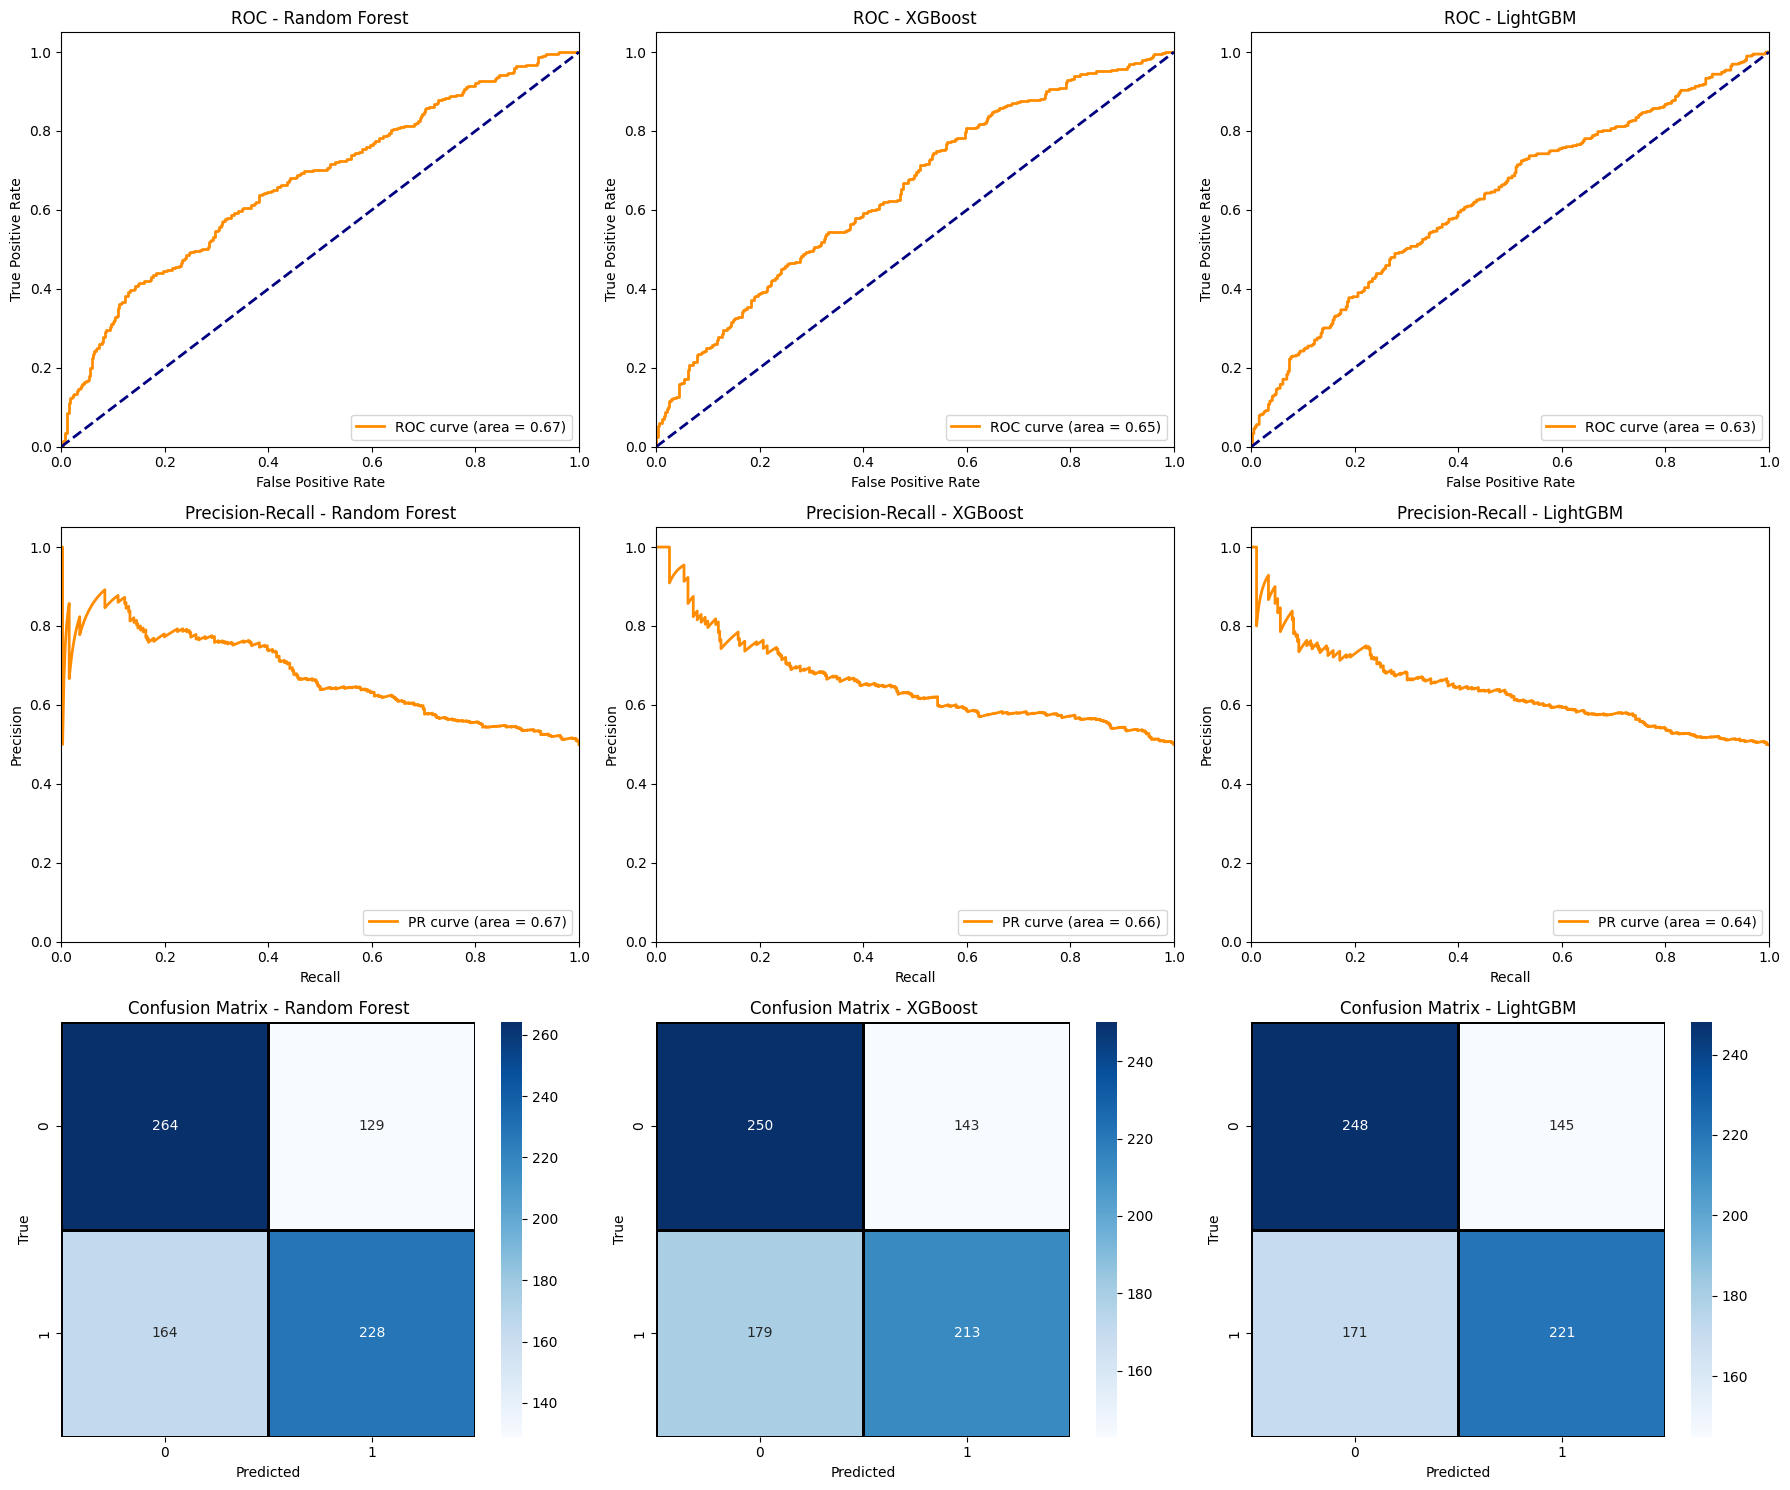

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [13]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.6267515923566879, 'Precision': 0.6386554621848739, 'Recall': 0.5816326530612245, 'F1 Score': 0.6088117489986649, 'ROC AUC': 0.6697953990756609}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.5898089171974522, 'Precision': 0.598314606741573, 'Recall': 0.5433673469387755, 'F1 Score': 0.56951871657754, 'ROC AUC': 0.6505556421041699}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.597452229299363, 'Precision': 0.6038251366120219, 'Recall': 0.5637755102040817, 'F1 Score': 0.58311345646438, 'ROC AUC': 0.6300014280521369}


In [14]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.597452229299363,
 'Precision': 0.6038251366120219,
 'Recall': 0.5637755102040817,
 'F1 Score': 0.58311345646438,
 'ROC AUC': 0.6300014280521369}

In [15]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: Random Forest with Accuracy: 0.6268


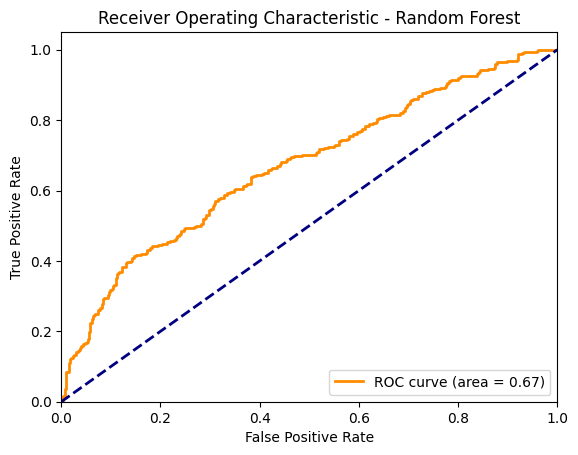

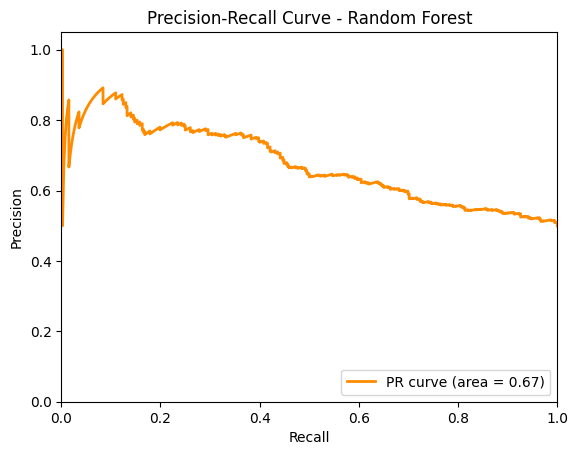

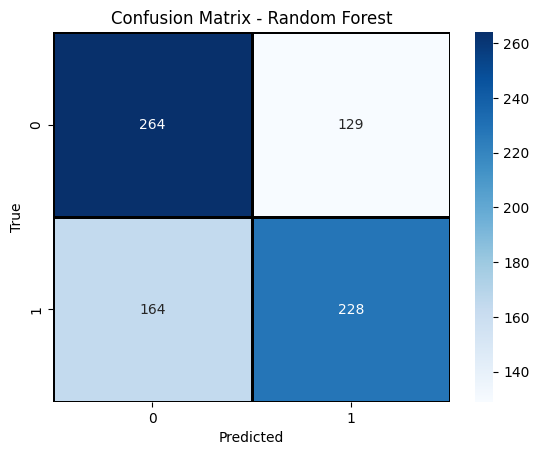

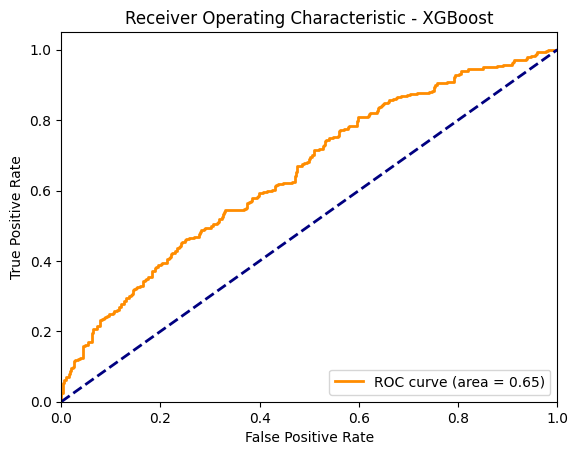

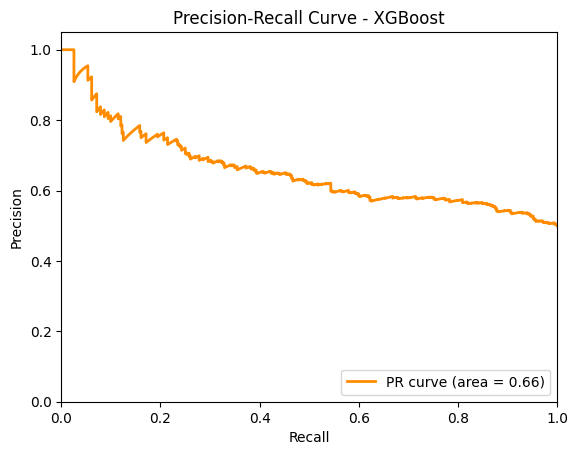

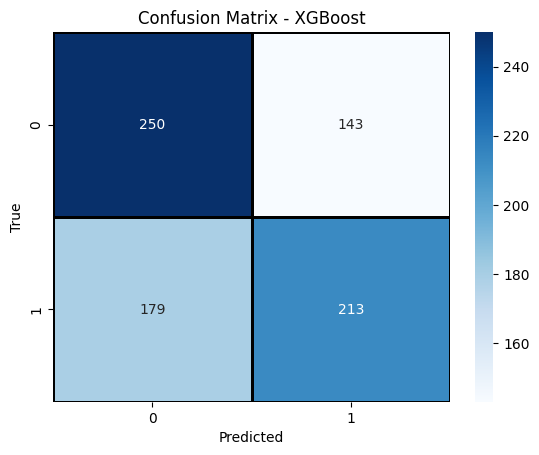

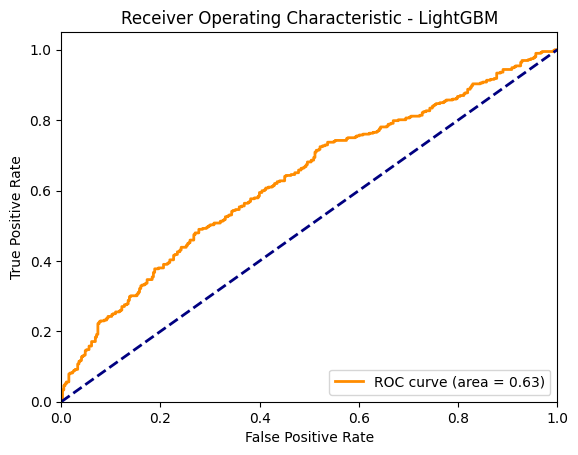

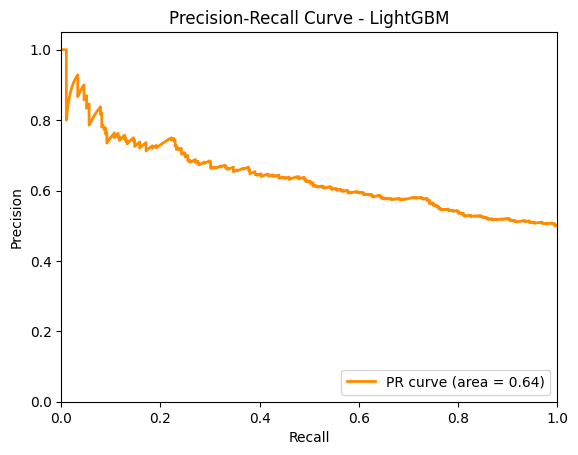

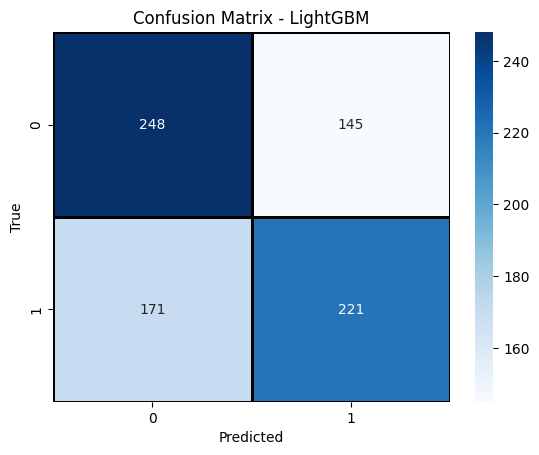

In [16]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [17]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

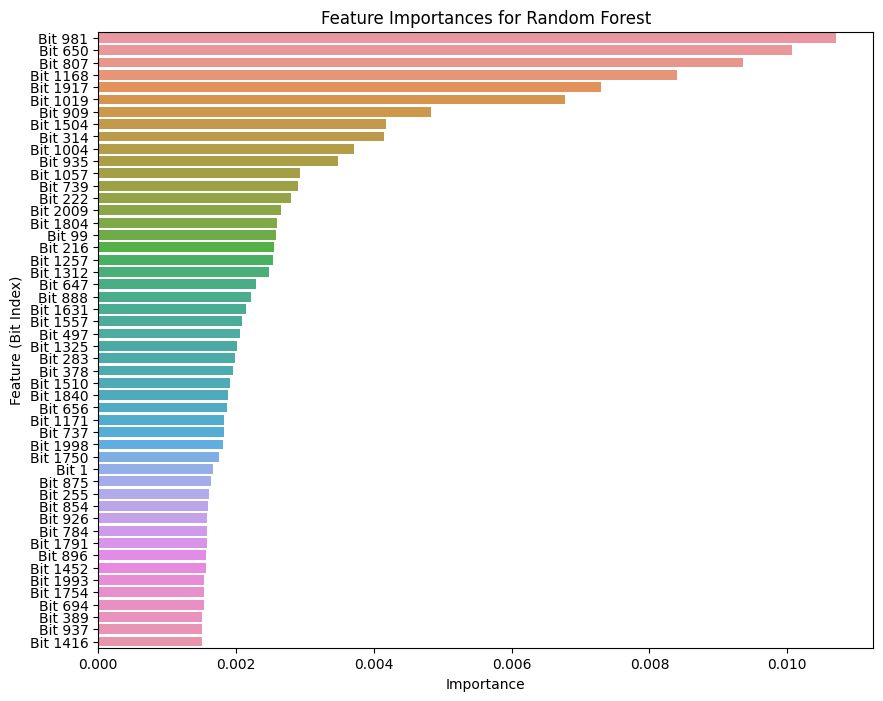

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [19]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
